In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Motive is to analyse and predict House price


My Game plan is:
* Basic EDA
* Data Wrangling
* Some Visualization Analysis
* Some Time Series analysis
* Using model (Statistic / Machine Learning)
* Predict Model
* Choose best one

In [3]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 10.6 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [5]:
data = pd.read_csv('/content/raw_sales.csv')
data.head()

,datesold,postcode,price,propertyType,bedrooms
0,2007-02-07 00:00:00,2607,525000,house,4
1,2007-02-27 00:00:00,2906,290000,house,3
2,2007-03-07 00:00:00,2905,328000,house,3
3,2007-03-09 00:00:00,2905,380000,house,4
4,2007-03-21 00:00:00,2906,310000,house,3


# This Dataset contains 5 columns

If we look carefully on date column, we can found, this data doesn't contain everyday's data or data is not synchronized.. Look at the 1st 2 rows 1st rows date is 2007-02-07 where as second row contains 2007-02-27th day's value. 

In [6]:
data.tail()

,datesold,postcode,price,propertyType,bedrooms
29575,2019-07-25 00:00:00,2900,500000,unit,3
29576,2019-07-25 00:00:00,2612,560000,unit,2
29577,2019-07-26 00:00:00,2912,464950,unit,2
29578,2019-07-26 00:00:00,2601,589000,unit,2
29579,2019-07-26 00:00:00,2612,775000,unit,2


In [8]:
data.dtypes

datesold        object
postcode         int64
price            int64
propertyType    object
bedrooms         int64
dtype: object

In [9]:
data.index = pd.to_datetime(data.datesold)

In [10]:
data['propertyType'].unique()

array(['house', 'unit'], dtype=object)

There have 2 types of properties..


# Looking If data set is Stationary or non stationary using Augmented Dicky Fuller method...

**If P-value > 0.05 then given column is non-stationary else stationary**

**Stationary** : If data contains almost constant mean, variance \
**Non-Stationary** : Mean, Variance change over time 

In [11]:
print(f"P-Value: {adfuller(data['bedrooms'])[1]}")
print(f"P-Value: {adfuller(data['price'])[1]}")

P-Value: 0.00463829143542199
P-Value: 1.574525168057127e-18


# Both Price and Bedrooms are stationary 



# Visualization


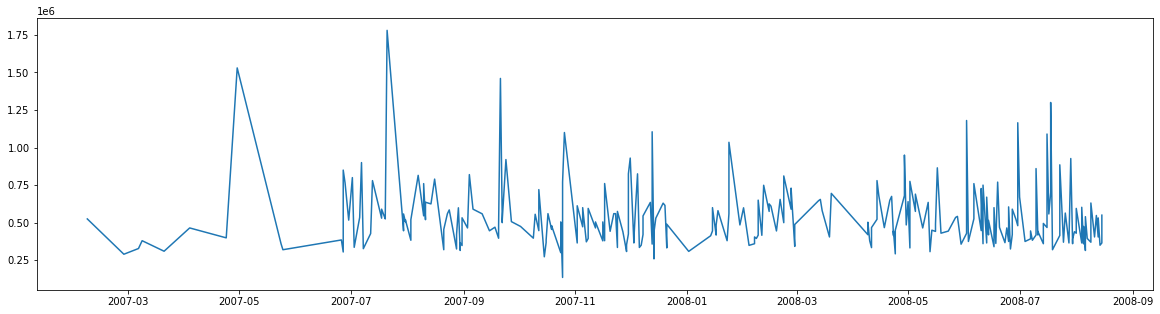

In [12]:
plt.figure(figsize = (20,5))
plt.plot(data['price'][:300])
plt.show()

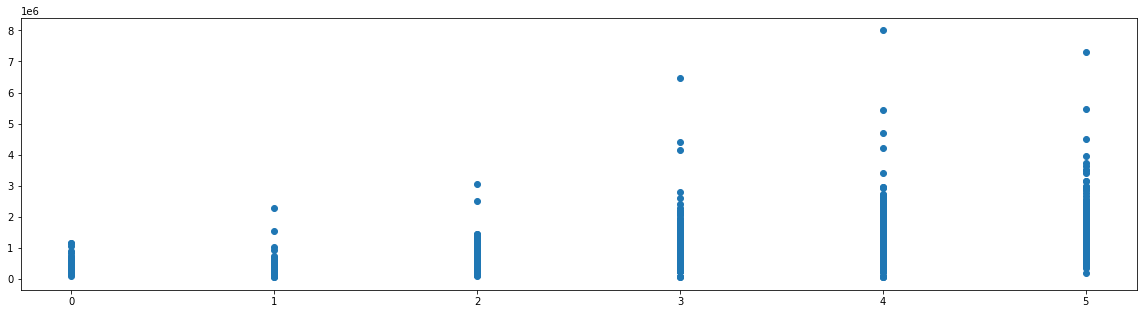

In [13]:
plt.figure(figsize = (20,5))
plt.scatter(data['bedrooms'],data['price'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


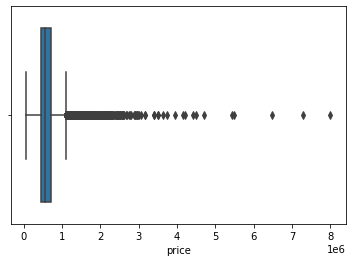

In [14]:
sns.boxplot(data['price'])
plt.show()

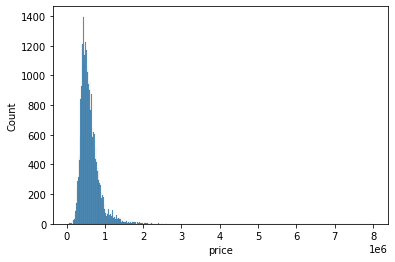

In [15]:
sns.histplot(data['price'])
plt.show()

**Both Boxplot and Histgram plots indicate strong Right skewness. Which is a bad data distribution. To remove right skewness,we can use simple log transformation**

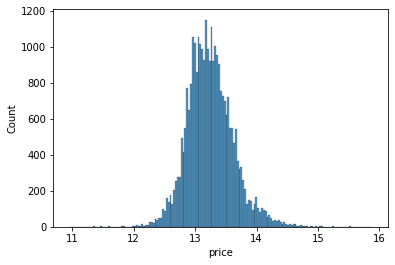

In [16]:
data['price'] = np.log(data['price'])
sns.histplot(data['price'])
plt.show()

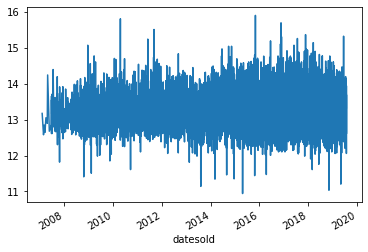

In [17]:
data.price.plot()

In [18]:
data.dtypes

datesold         object
postcode          int64
price           float64
propertyType     object
bedrooms          int64
dtype: object

In [19]:
data.index = pd.to_datetime(data.datesold)

# As dataset is not containing regular/daily data, We can use just monthly avg data. That will give us atleast regular data.

In [20]:
from sklearn.preprocessing import LabelEncoder
data['propertyType'] = LabelEncoder().fit_transform(data['propertyType'])
data = data.resample('m').mean()
data.head(20)

,postcode,price,propertyType,bedrooms
datesold,,,,
2007-02-28,2756.500000,12.874395,0.000000,3.500000
2007-03-31,2905.333333,12.731008,0.000000,3.333333
2007-04-30,2706.000000,13.395763,0.000000,3.666667
2007-05-31,2904.000000,12.733577,0.000000,3.000000
2007-06-30,2757.500000,13.076171,0.166667,3.333333
2007-07-31,2668.684211,13.195712,0.157895,3.263158
2007-08-31,2775.869565,13.092396,0.086957,3.391304
2007-09-30,2681.950000,13.154373,0.300000,3.300000
2007-10-31,2743.500000,13.037159,0.100000,3.300000


In [21]:
for i in range(len(data['propertyType'])):
    data['propertyType'][i] =1 if data['propertyType'][i] > 0.000000 else 0 

In [22]:
for i in range(len(data['bedrooms'])):
    data['bedrooms'][i] =np.round(data['bedrooms'][i])

In [23]:
data = data.dropna()

In [24]:
result = seasonal_decompose(data['price'])

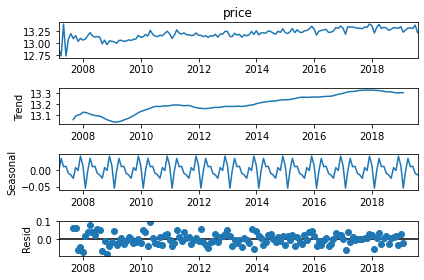

In [25]:
result.plot();

# This plot indicates price is up trending over time also there have seasonality

**Trend** : Significant change over time either upwards or downwards. Look at the trend graph 2008 - 2009 trend was downward and rest of years it's increasing. \
**Seasonality**: If there have some event repeat/happening every particular time. If we see Seasonal graph every January of a year line is dropped and October - December has it's highest peak and it's repeating every single year.

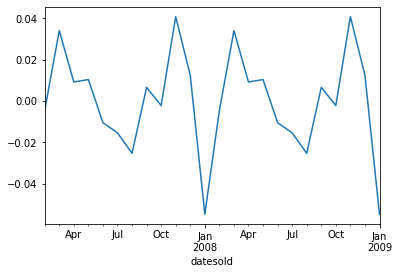

In [26]:
result.seasonal[:24].plot();

**Split data set, 70% as training and rest of it as test data.**

In [27]:
data = data.drop(columns = ['postcode'])

In [28]:
train_size = int(len(data)*.7)
print(train_size,len(data))


105 150


In [45]:
train = data.iloc[:train_size]
test = data.iloc[train_size:]
X_train = train.drop(columns = ['price'])
y_train = train[['price']]

In [46]:
X_test=test.drop(columns = ['price'])
y_test= train[['price']]


In [48]:
X_test


,propertyType,bedrooms,year,month
datesold,,,,
2015-11-30,1.0,3.0,2015,11
2015-12-31,1.0,3.0,2015,12
2016-01-31,1.0,3.0,2016,1
2016-02-29,1.0,3.0,2016,2
2016-03-31,1.0,3.0,2016,3
2016-04-30,1.0,3.0,2016,4
2016-05-31,1.0,3.0,2016,5
2016-06-30,1.0,3.0,2016,6
2016-07-31,1.0,3.0,2016,7


# Train data using default features with catboost regressor 

In [30]:
model = CatBoostRegressor(silent =True)
model.fit(train_feature,train_label)

77011.32335092747


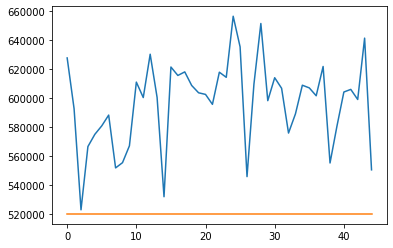

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

test_feature = test.drop(columns = ['price'])
test_label = test[['price']]
pred = model.predict(test_feature)
test_label = np.exp(test_label)
pred = np.exp(pred)
print(mean_absolute_error(test_label,pred))
plt.plot(np.array(test_label))
plt.plot(np.array(pred))
plt.show()



# Adding More features , Again train using Catboost ,Linear,Lightboost algos

In [32]:
data['year'] = data.index.year
data['month'] = data.index.month
# data['date'] = data.index.day


In [33]:
data.head()

,price,propertyType,bedrooms,year,month
datesold,,,,,
2007-02-28,12.874395,0.0,4.0,2007,2
2007-03-31,12.731008,0.0,3.0,2007,3
2007-04-30,13.395763,0.0,4.0,2007,4
2007-05-31,12.733577,0.0,3.0,2007,5
2007-06-30,13.076171,1.0,3.0,2007,6


In [34]:
train = data.iloc[:train_size]
test = data.iloc[train_size:]
train_feature = train.drop(columns = ['price'])
train_label = train[['price']]
model = CatBoostRegressor(silent=True)
model.fit(train_feature,train_label)

29610.610819389545


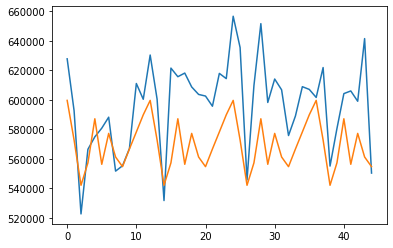

In [35]:
test_feature = test.drop(columns = ['price'])
test_label = test[['price']]
pred = model.predict(test_feature)
test_label = np.exp(test_label)
pred = np.exp(pred)
print(mean_absolute_error(test_label,pred))
plt.plot(np.array(test_label))
plt.plot(np.array(pred))
plt.show()


In [36]:
lr = LinearRegression()
lr.fit(train_feature,train_label)

LinearRegression()

22705.767435568992


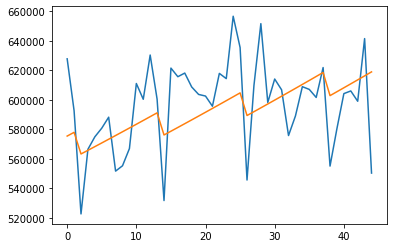

In [37]:
test_feature = test.drop(columns = ['price'])
test_label = test[['price']]
pred = lr.predict(test_feature)
test_label = np.exp(test_label)
pred = np.exp(pred)
print(mean_absolute_error(test_label,pred))
plt.plot(np.array(test_label))
plt.plot(np.array(pred))
plt.show()

In [38]:
lgb = LGBMRegressor()
lgb.fit(train_feature,train_label)

LGBMRegressor()

22705.767435568992


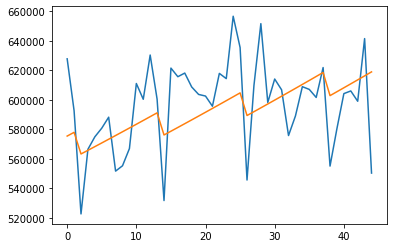

In [39]:
test_feature = test.drop(columns = ['price'])
test_label = test[['price']]
pred = lr.predict(test_feature)
test_label = np.exp(test_label)
pred = np.exp(pred)
print(mean_absolute_error(test_label,pred))
plt.plot(np.array(test_label))
plt.plot(np.array(pred))
plt.show()

In [40]:
pip install dynamask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=53e4f5787346aafcf2de9c0c272a1810cfe02b8d208bff57e09ac74d92b9e575
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [41]:
from dynamask.fit.TSX.utils import load_data
import torch
import torch.utils.data as utils
from torch.utils.data import DataLoader
from dynamask.attribution.perturbation import FadeMovingAverage
from  dynamask.attribution.perturbation import GaussianBlur
from torch.nn.functional import mse_loss
from dynamask.attribution.mask import Mask
#from dynamask.models.models import StateClassifier
from dynamask.attribution.mask_group import MaskGroup

In [42]:
def blackbox1(x):
    out=model.predict(x.detach().cpu().numpy())
    return torch.tensor(out)

In [54]:
def blackbox2(x):
    out=lr.predict(x.detach().cpu().numpy())
    return torch.tensor(out)

In [43]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('GPU')
else:
    device = torch.device('cpu')
    print('CPU')

CPU


In [59]:
pert = GaussianBlur(device,sigma_max=2.0)
mask = MaskGroup(pert, device)

In [60]:
areas = [0.1, 0.25,0.35,0.45,0.55,0.65,0.66,0.70,0.80]
mask.fit(torch.tensor(X_test.values, dtype=torch.float), f=blackbox2, loss_function=mse_loss, size_reg_factor_init=0.01,area_list=areas,learning_rate=2.5, size_reg_factor_dilation=10000, initial_mask_coeff=0.5, n_epoch=2000, momentum=1.0, time_reg_factor=2)


Epoch 1/2000: error = 1.51e-05 ; size regulator = 0.25 ; time regulator = 0 ; time elapsed = 0.00622 s
Epoch 2/2000: error = 1.51e-05 ; size regulator = 0.25 ; time regulator = 2.43e-06 ; time elapsed = 0.00744 s
Epoch 3/2000: error = 1.51e-05 ; size regulator = 0.249 ; time regulator = 0.000934 ; time elapsed = 0.00692 s
Epoch 4/2000: error = 1.51e-05 ; size regulator = 0.249 ; time regulator = 0.000909 ; time elapsed = 0.00697 s
Epoch 5/2000: error = 1.52e-05 ; size regulator = 0.249 ; time regulator = 0.00148 ; time elapsed = 0.00692 s
Epoch 6/2000: error = 1.51e-05 ; size regulator = 0.249 ; time regulator = 0.00135 ; time elapsed = 0.00695 s
Epoch 7/2000: error = 1.51e-05 ; size regulator = 0.249 ; time regulator = 0.00218 ; time elapsed = 0.00709 s
Epoch 8/2000: error = 1.51e-05 ; size regulator = 0.249 ; time regulator = 0.00236 ; time elapsed = 0.00682 s
Epoch 9/2000: error = 1.51e-05 ; size regulator = 0.248 ; time regulator = 0.00245 ; time elapsed = 0.00695 s
Epoch 10/2000: 

The mask of area 0.1 is extremal with error = 3.6e-05.


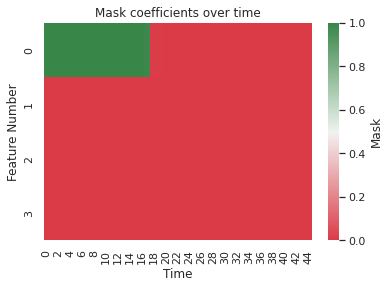

In [61]:
masks = mask.get_extremal_mask(threshold=0.3)
masks.plot_mask(smooth= False, sigma=2.0)

In [57]:
X_test[0:24]

,propertyType,bedrooms,year,month
datesold,,,,
2015-11-30,1.0,3.0,2015,11
2015-12-31,1.0,3.0,2015,12
2016-01-31,1.0,3.0,2016,1
2016-02-29,1.0,3.0,2016,2
2016-03-31,1.0,3.0,2016,3
2016-04-30,1.0,3.0,2016,4
2016-05-31,1.0,3.0,2016,5
2016-06-30,1.0,3.0,2016,6
2016-07-31,1.0,3.0,2016,7


In [58]:
X_test[24:44]

,propertyType,bedrooms,year,month
datesold,,,,
2017-11-30,1.0,3.0,2017,11
2017-12-31,1.0,3.0,2017,12
2018-01-31,1.0,3.0,2018,1
2018-02-28,1.0,3.0,2018,2
2018-03-31,1.0,3.0,2018,3
2018-04-30,1.0,3.0,2018,4
2018-05-31,1.0,3.0,2018,5
2018-06-30,1.0,3.0,2018,6
2018-07-31,1.0,3.0,2018,7
